In [1]:
import sys
sys.path.append("../src")
from utils import *

In [2]:
datadir

'../data'

In [3]:
sample_sheet = pd.read_csv(os.path.join(datadir, "cohort_overview.csv"), index_col=0)

In [4]:
sample_sheet = sample_sheet[sample_sheet.ustekinumab=="no"]
sample_sheet = sample_sheet[sample_sheet.discard=="no"]

In [5]:
visium_samples = list(set(sample_sheet.Visium_sample_name.dropna().tolist()))

In [6]:
len(visium_samples)

20

In [7]:
# visium_samples

In [8]:
p="/data/projects/ANCA_Atlas/Visum/alignment_Visium_FFPE"
anca_samples = [os.path.join(p, sample) for sample in visium_samples]

In [9]:
all_samples = anca_samples

In [10]:
rel_metrics_path="outs/metrics_summary.csv"
for sample in all_samples:
    if sample==all_samples[0]:
        df_metrics = pd.read_csv(os.path.join(sample, rel_metrics_path), index_col=0)
    else:
        tmp = pd.read_csv(os.path.join(sample, rel_metrics_path), index_col=0)
        df_metrics = pd.concat([df_metrics, tmp], axis=0)

In [11]:
df_metrics.to_csv(os.path.join(datadir, "anca_samples_metrics.csv"))

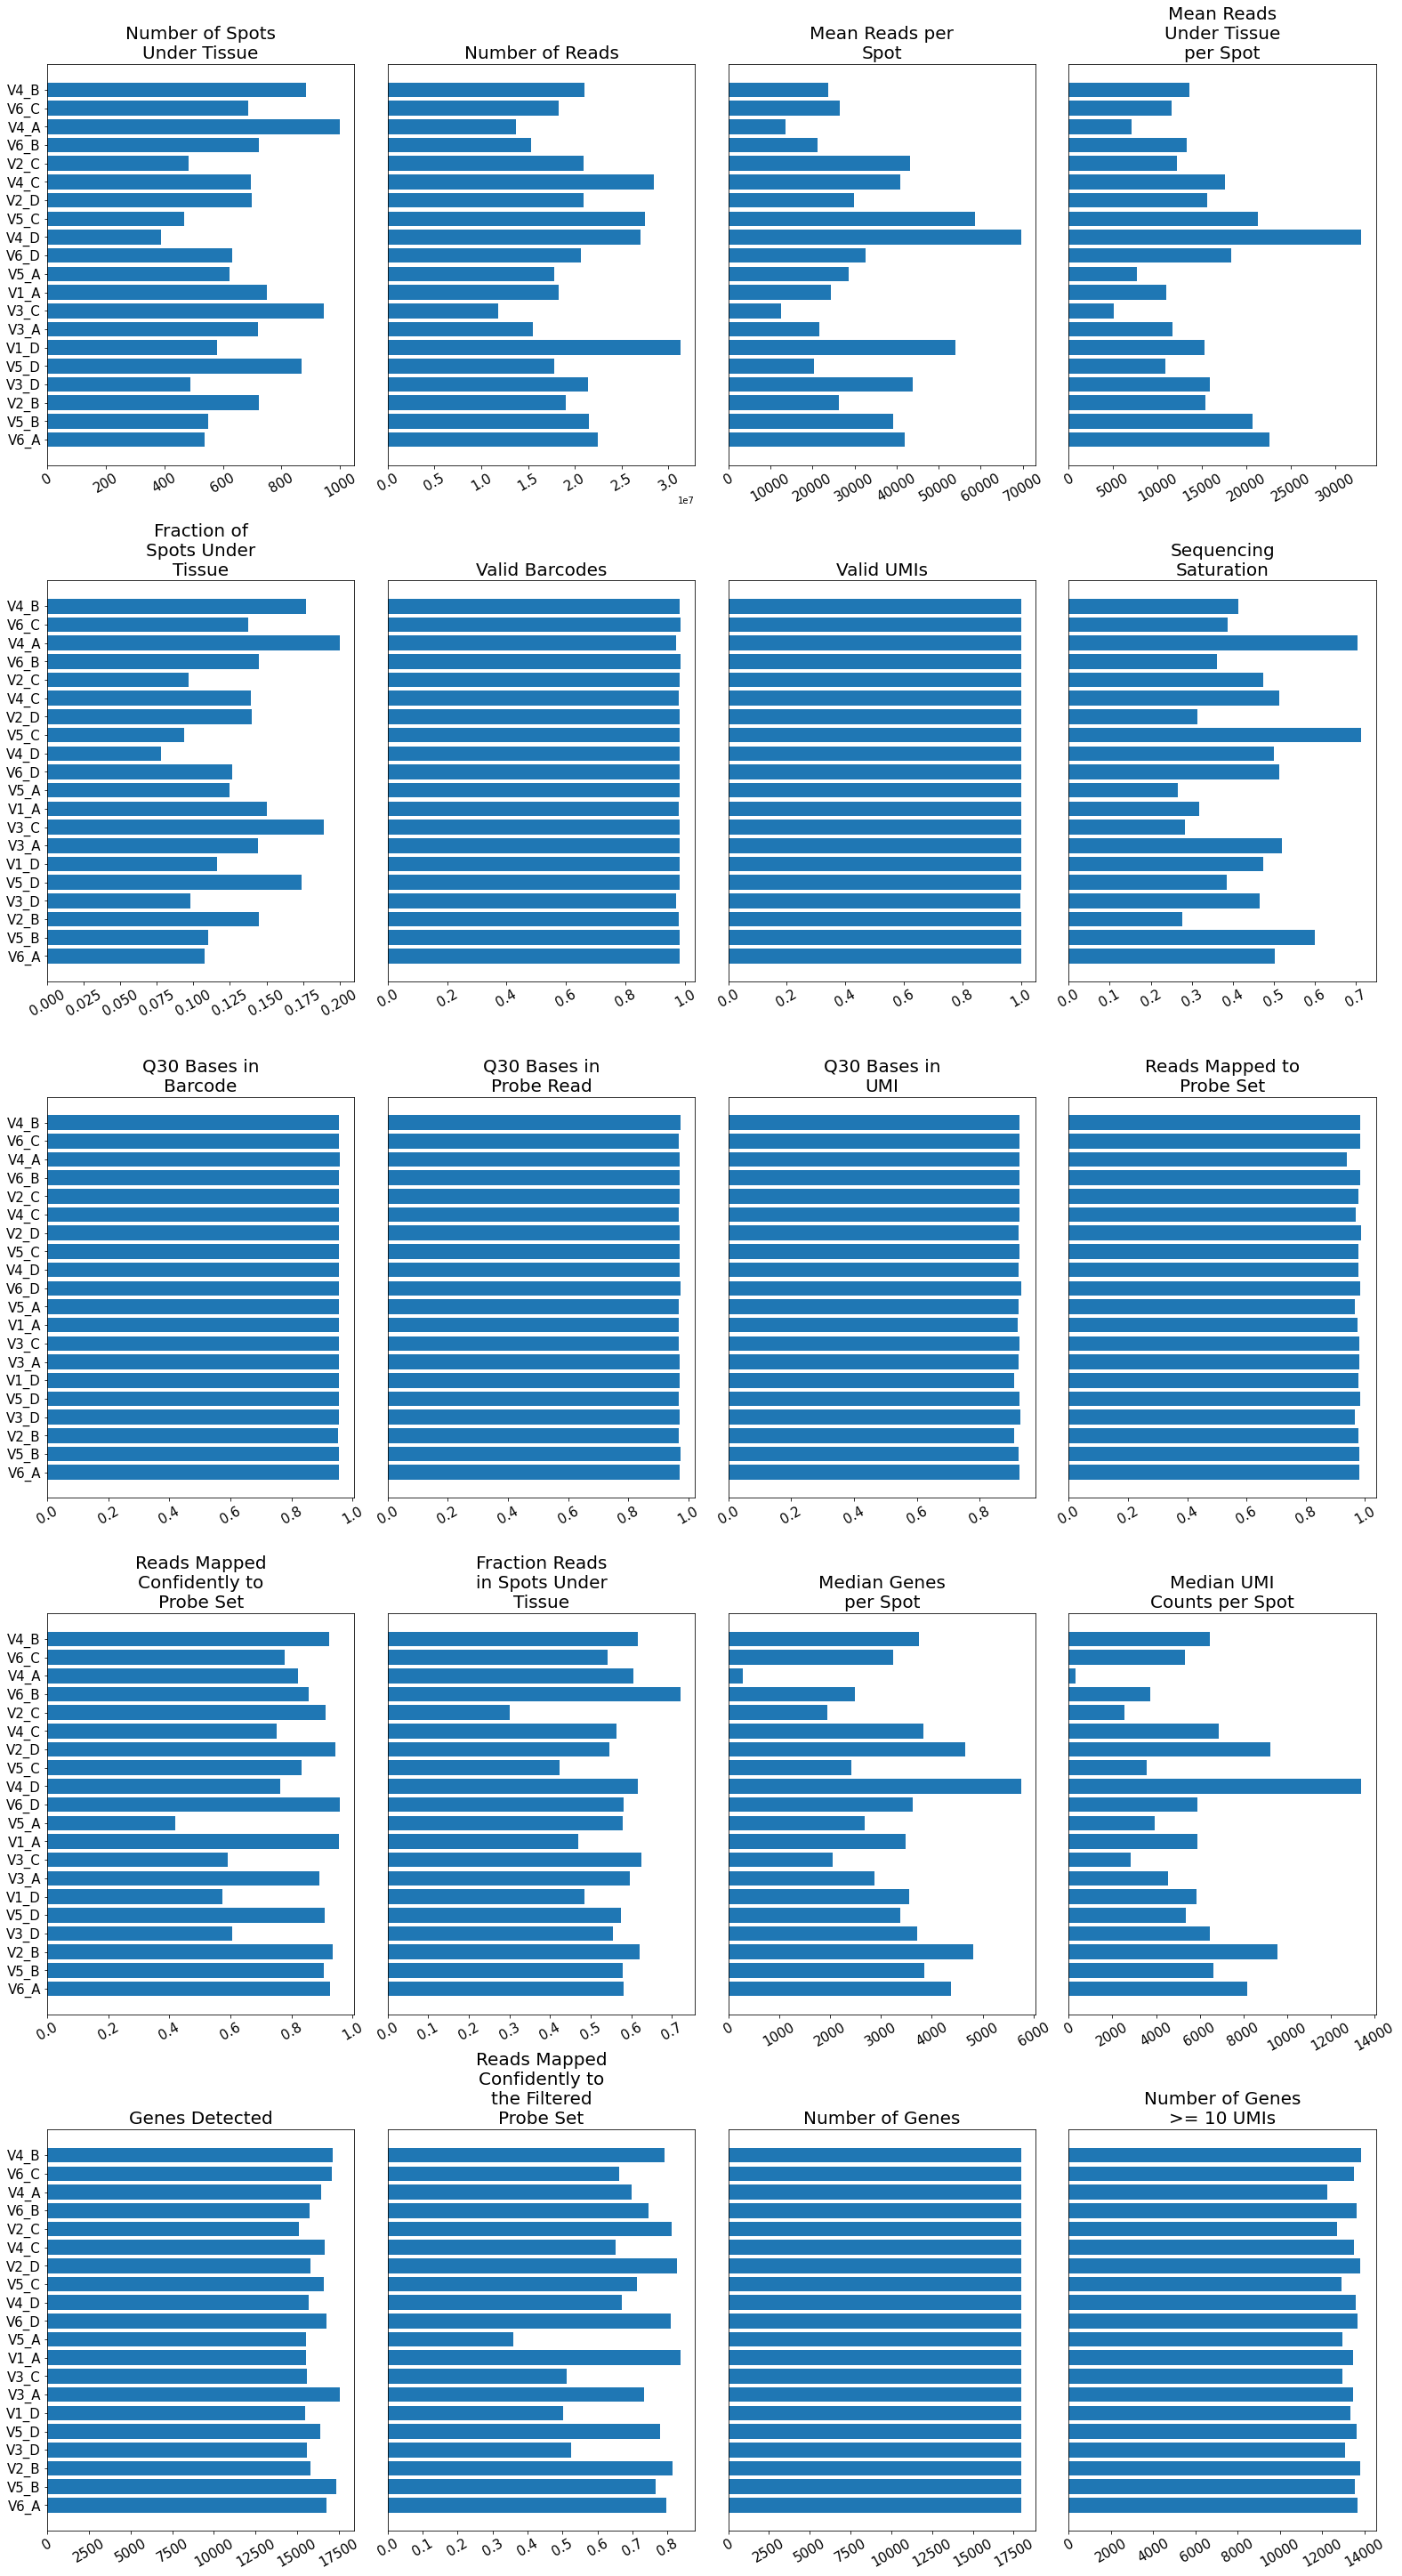

In [12]:
chartQC(df_metrics, show=True, savepath=os.path.join(figdir, "anca_samples_metrics_summary.pdf"))

In [13]:
rm_samples = ["/data/projects/ANCA_Atlas/Visum/alignment_Visium_FFPE/V4_A"]
batch_key="Sample"

In [14]:
import warnings
warnings.filterwarnings("ignore") # ignore printing many UserWarning produced during reading multiple anndata (var names not unique etc.)

In [15]:
all_samples = list(set(all_samples))

In [16]:
from tqdm import tqdm

In [17]:
i=0
for sample in tqdm(all_samples):
    if sample not in rm_samples:
        if "_filtered" not in sample:
            tmp = read_visium(os.path.join(sample, "outs"))
        # else:
        #     tmp = sc.read_10x_h5(sample)
            tmp.var_names_make_unique()
            sample_name = sample.split("/")[-1].split(".")[0].split("_filtered")[0]
            tmp.obs[batch_key] = sample_name
            sample = sample_name
            tmp.obs.index = [idx+"_{}".format(sample_name) for idx in tmp.obs.index]
            if i==0:
                adata = tmp
                i=1
            else:
                adata = adata.concatenate(tmp, uns_merge="unique", index_unique=None)

adata.obs = adata.obs[[col for col in adata.obs.columns if col!="batch"]]

100%|██████████| 20/20 [00:12<00:00,  1.57it/s]


In [18]:
adata.raw = adata.copy()

In [19]:
"No. of spots: {}, No. of genes: {}, No. of samples: {}".format(adata.shape[0], adata.shape[1], adata.obs.Sample.unique().shape[0])

'No. of spots: 12444, No. of genes: 17943, No. of samples: 19'

In [20]:
target_sum=1e4
min_genes=100
min_spots=3
n_comps=50
n_neighbors=10
use_highly_variable=True
mt_cutoff=20
min_counts=2000
max_counts=35000

In [21]:
adata.var["mt"] = adata.var_names.str.startswith("MT-") # FFPE has no mito. genes
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

<AxesSubplot:xlabel='n_genes_by_counts'>

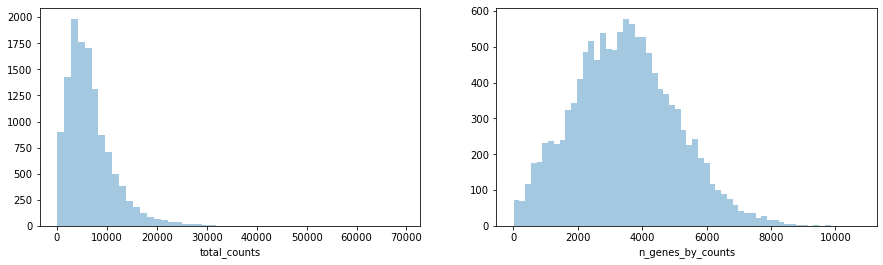

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[1])

In [24]:
sc.pp.filter_cells(adata, min_genes=min_genes)
sc.pp.filter_cells(adata, min_counts=min_counts)
sc.pp.filter_cells(adata, max_counts=max_counts)
sc.pp.filter_genes(adata, min_cells=min_spots)

In [25]:
"No. of spots: {}, No. of genes: {}, No. of samples: {}".format(adata.shape[0], adata.shape[1], adata.obs.Sample.unique().shape[0])

'No. of spots: 10976, No. of genes: 17843, No. of samples: 19'

<AxesSubplot:xlabel='n_genes_by_counts'>

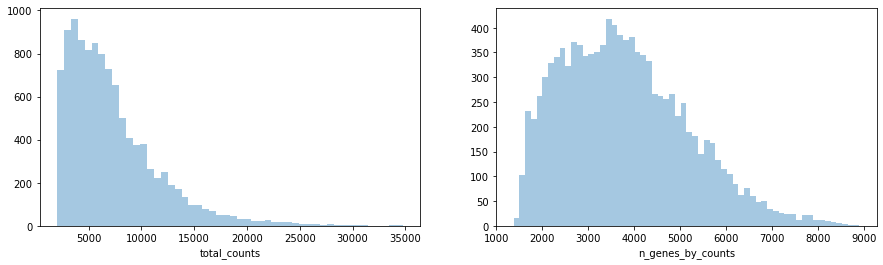

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[1])

In [27]:
adata.obs["Condition"] = "ANCA"

In [28]:
sc.pp.normalize_total(adata, target_sum=target_sum)
sc.pp.log1p(adata)

In [29]:
sc.pp.highly_variable_genes(adata, batch_key="Sample")

In [30]:
sc.tl.pca(adata, random_state=seed, use_highly_variable=True, n_comps=50)

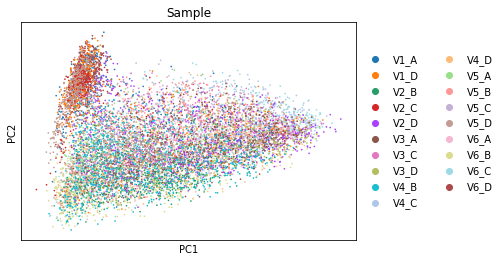

In [31]:
sc.pl.pca(adata, color="Sample")

In [32]:
sc.external.pp.harmony_integrate(adata, key="Sample", max_iter_harmony=50)

2023-11-08 08:55:46,525 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-11-08 08:55:49,835 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-11-08 08:55:49,876 - harmonypy - INFO - Iteration 1 of 50
2023-11-08 08:55:51,961 - harmonypy - INFO - Iteration 2 of 50
2023-11-08 08:55:54,035 - harmonypy - INFO - Iteration 3 of 50
2023-11-08 08:55:56,053 - harmonypy - INFO - Iteration 4 of 50
2023-11-08 08:55:58,070 - harmonypy - INFO - Iteration 5 of 50
2023-11-08 08:56:00,095 - harmonypy - INFO - Iteration 6 of 50
2023-11-08 08:56:02,105 - harmonypy - INFO - Iteration 7 of 50
2023-11-08 08:56:03,825 - harmonypy - INFO - Converged after 7 iterations


In [33]:
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=50, use_rep="X_pca_harmony")

In [34]:
sc.tl.umap(adata)
adata.uns["Sample_colors"] = sns.color_palette("colorblind",len(adata.obs.Sample.unique())).as_hex()

In [35]:
sc.set_figure_params(dpi=100)
plt.rcParams["font.family"] = ["Inter"]

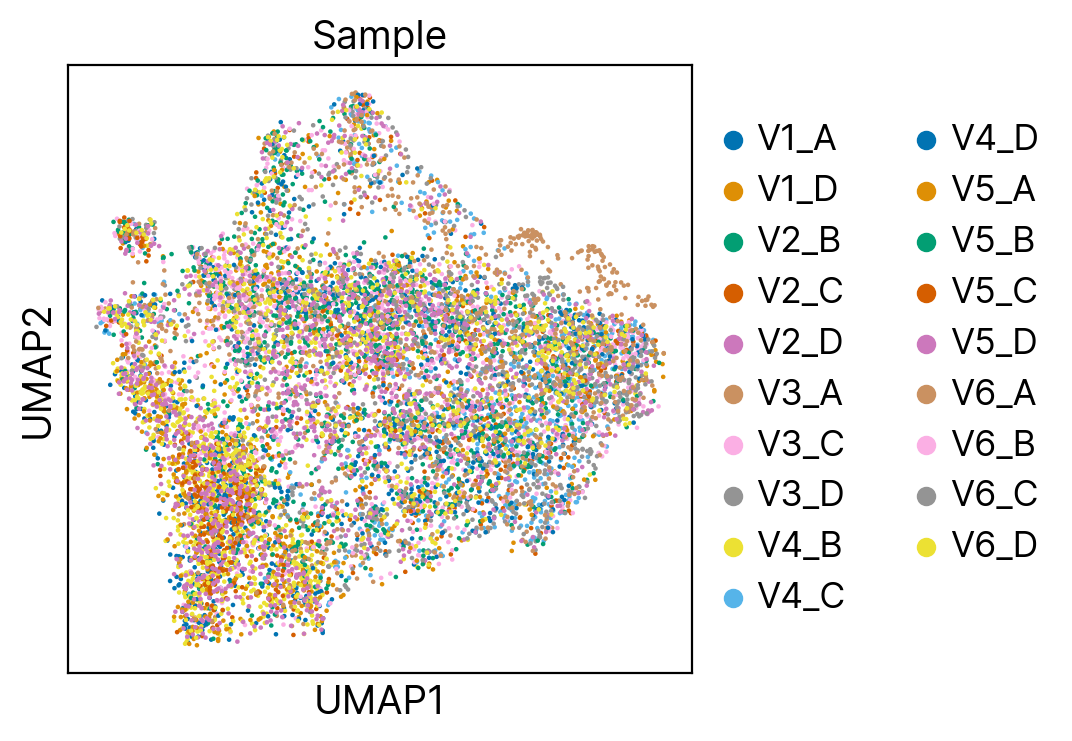

In [36]:
sc.pl.umap(adata, color=["Sample"], show=False)
plt.savefig(os.path.join(figdir, "UMAP_anca_samples_coloredBySample.pdf"), bbox_inches="tight")

In [37]:
df_de = pd.read_csv("/data/projects/robin/singlecell/de_structure.csv", index_col=0)
df_de_region = pd.read_csv("/data/projects/robin/singlecell/de_regions.l1.csv", index_col=0)

df_de = df_de[df_de.names.isin(adata.var_names.tolist())]
df_de_region = df_de_region[df_de_region.names.isin(adata.var_names.tolist())]

df_de = df_de[(df_de.logfoldchanges>0.25)&(df_de.pct_nz_group>0.25)]
df_de_region = df_de_region[(df_de_region.logfoldchanges>0.25)&(df_de_region.pct_nz_group>0.25)]

In [38]:
tmp = adata.copy()
tmp.X = adata.X.copy()
sc.pp.scale(tmp, max_value=10)
for group in df_de.group.unique():
    score_genes = df_de[df_de.group==group].names.tolist()[:50]
    sc.tl.score_genes(tmp, gene_list=score_genes, score_name=group, copy=False)
    adata.obs[f"{group}_score"] = tmp.obs[group].tolist()

In [39]:
res = 1
sc.tl.leiden(adata, key_added=f"leiden_{res}")

In [40]:
for group in df_de_region.group.unique():
    score_genes = df_de_region[df_de_region.group==group].names.tolist()
    if len(score_genes)>0:
        sc.tl.score_genes(tmp, gene_list=score_genes, score_name=group, copy=False)
        adata.obs[f"region_{group}_score"] = tmp.obs[group].tolist()

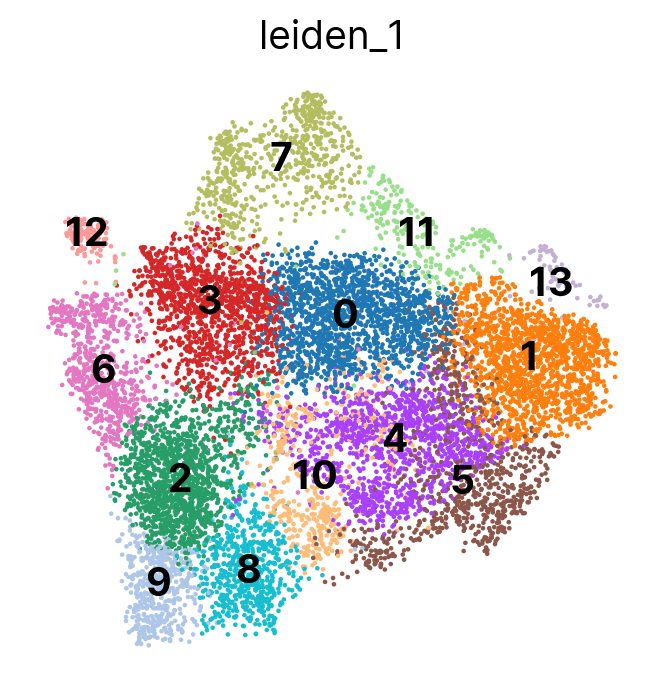

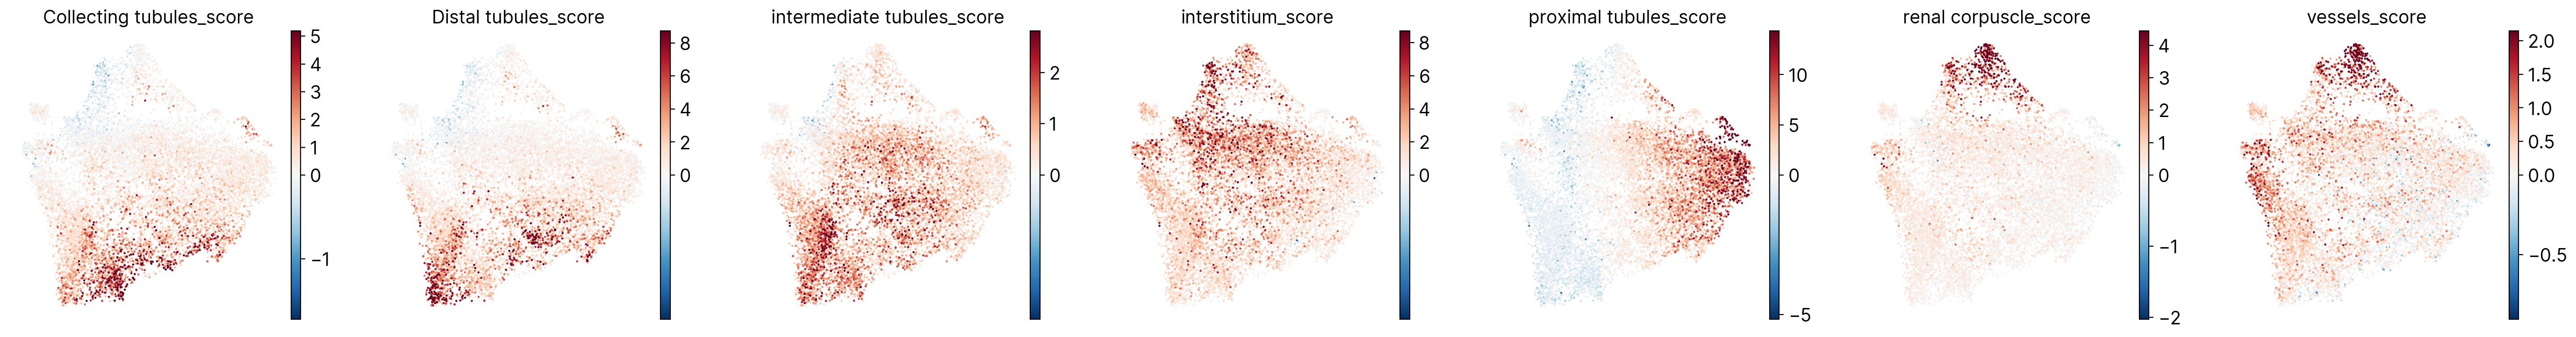

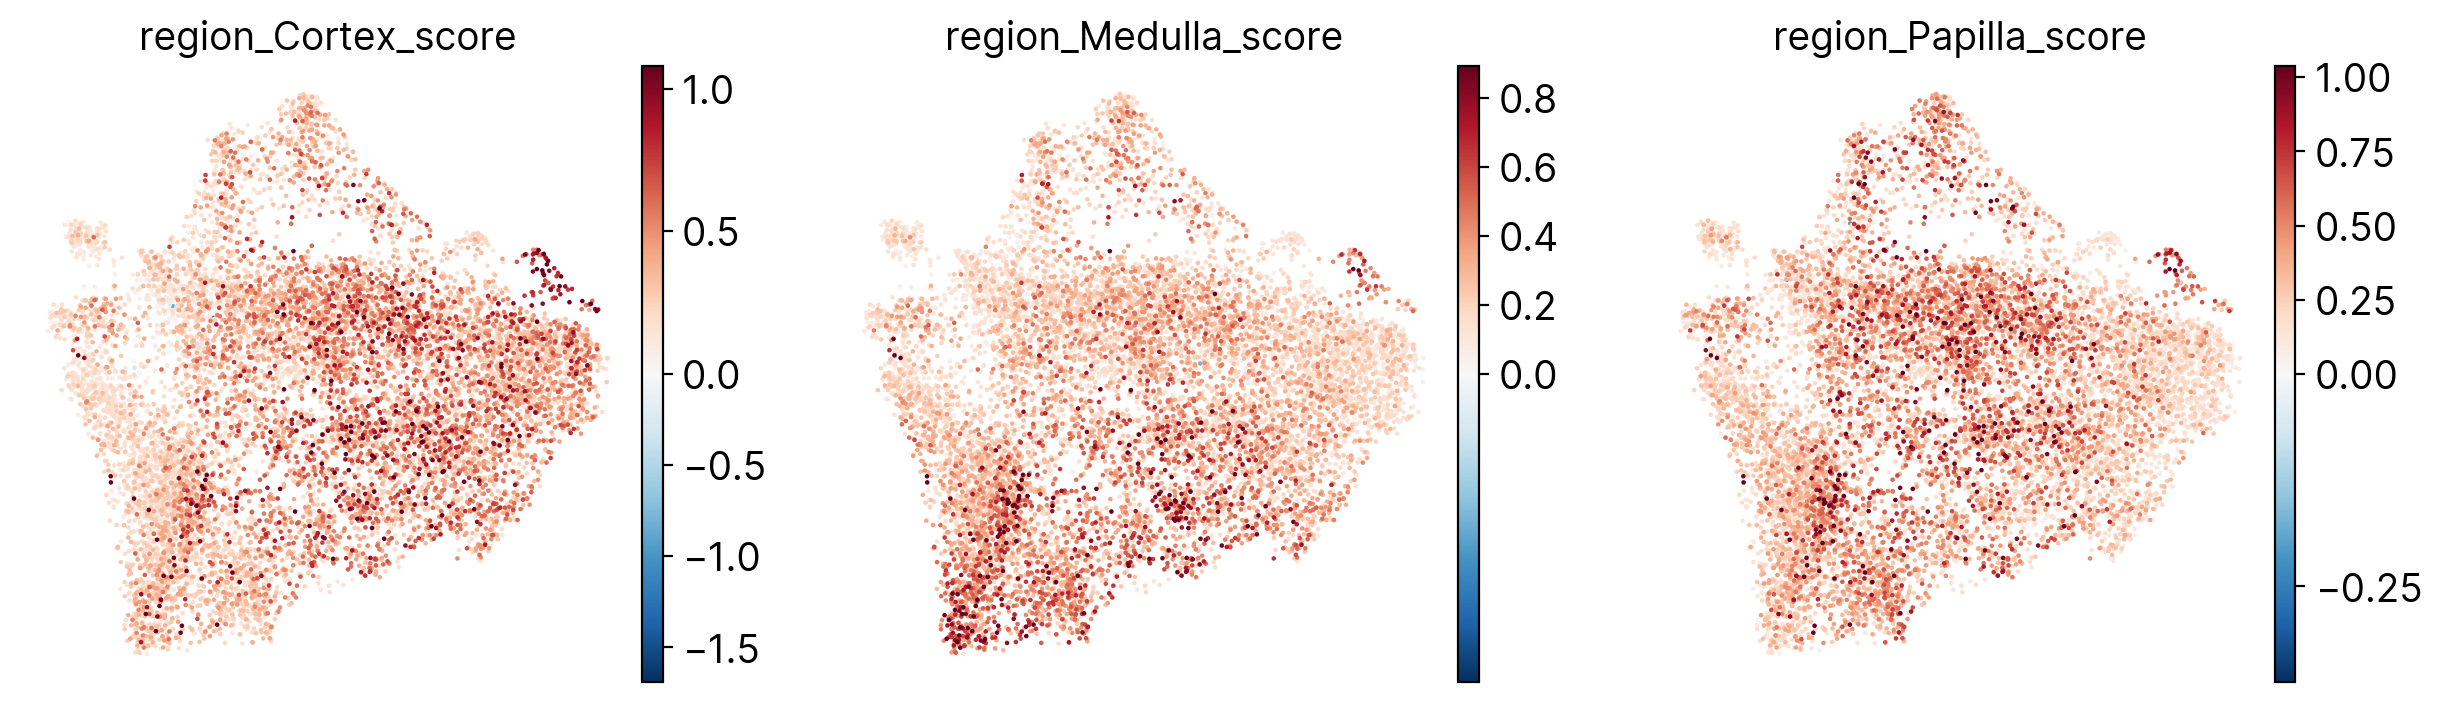

In [41]:
n = len(df_de.group.unique().tolist())
sc.pl.umap(adata, color=[f"leiden_{res}"], vmax="p99", frameon=False, ncols=3, 
           use_raw=False, vcenter=0, cmap="RdBu_r", legend_loc="on data", title=f"leiden_{res}", show=False)

sc.pl.umap(adata, color=[f"{group}_score" for group in df_de.group.unique()], vmax="p99", frameon=False, ncols=7, 
           use_raw=False, vcenter=0, cmap="RdBu_r", show=False)
plt.savefig(os.path.join(figdir, "UMAP_anca_samples_coloredByStructureScoresLake.pdf"), bbox_inches="tight")
sc.pl.umap(adata, color=[f"region_{group}_score" for group in df_de_region.group.unique() if str(group)!="nan"], 
           vmax="p99", frameon=False, ncols=7, 
           use_raw=False, vcenter=0, cmap="RdBu_r", show=False)
plt.savefig(os.path.join(figdir, "UMAP_anca_samples_coloredByRegionScoresLake.pdf"), bbox_inches="tight")

In [42]:
del adata.uns["Sample_colors"]

In [43]:
adata.write(os.path.join(datadir, "anca_samples_processed.h5ad"))